<a href="https://colab.research.google.com/github/fdelattre/BibleReco/blob/main/Bible_NLP_SpaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application de quelques techniques NLP sur les textes bibliques

Le corpus biblique en français est disponible intégralement en ligne sur le site de l'[Association Épiscopale Liturgique pour les pays Francophones](https://www.aelf.org/bible).

Le texte a été préalablement scrappé depuis le site internet et formatté comme ceci :

| Champ | Description |
|---|---|
| TESTAMENT | Ancien 'AT', Nouveau 'NT' ou Psaumes 'PS' |
| LIVRE | Titre du livre (ex : "Lettre de Saint Paul Apôtre aux Romains") |
| CODE_LIVRE | Code du livre (ex : Rm) |
| CHAPITRE | Numéro du chapitre dans le livre |
| URL | Url sur le site de l'AELF |
| VERSET | numéro du verset |
| TEXTE | Texte du verset |


> Dans ce notebook, nous appliquerons quelques techniques de nettoyage de texte. Nous tenterons ensuite de visualiser les proximités qui existent entre les textes. Enfin, nous proposerons une sorte de moteur de recommandation biblique.

Quelques pré-requis sont nécessaires \:
* pandas
* numpy
* stopwordiso
* sklearn
* seaborn / matplotlib
* spacy (version >=3) et le modèle fr_core_news_lg





In [ ]:
! pip install 'spacy>=3'
! python -m spacy download fr_core_news_md
! pip install stopwordsiso

# Lecture et transformations des données

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
import pandas as pd
filepath = '/gdrive/MyDrive/Colab Notebooks/bible_aelf.parquet.gzip'
data = pd.read_parquet(filepath)
data.sample(5)

,TESTAMENT,LIVRE,CODE_LIVRE,CHAPITRE,URL,VERSET,TEXTE
24430,AT,Livre du Lévitique,Lv,14,https://www.aelf.org/bible/Lv/14,05,Puis il ordonnera d’immoler un des oiseaux sur...
15494,AT,Livre de la Genèse,Gn,37,https://www.aelf.org/bible/Gn/37,19,Ils se dirent l’un à l’autre : « Voici l’exper...
33423,AT,Livre de la Sagesse,Sg,19,https://www.aelf.org/bible/Sg/19,07,"On vit la nuée recouvrir le camp de son ombre,..."
4054,AT,Premier livre de Samuel,1S,27,https://www.aelf.org/bible/1S/27,05,David dit à Akish : « Si j’ai trouvé grâce à t...
19961,NT,Evangile de Jésus-Christ selon saint Jean,Jn,5,https://www.aelf.org/bible/Jn/5,13,Mais celui qui avait été rétabli ne savait pas...


## Nettoyage du texte
* Passage en minuscules
* retrait des signes de ponctuation et des chiffres
* retrait des stopwords en se basant sur la liste [Stopwords ISO](https://github.com/stopwords-iso)

In [5]:
import stopwordsiso as stopwords
import re

def clean_text(txt, remove_stop_words = True):
  
  txt_clean         =  ''.join([re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', r.lower()) for r in txt])
  
  if remove_stop_words:
    stopWords         = set(stopwords.stopwords("fr"))  # French stopwords
    txt_clean = ' '.join([item for item in txt_clean.split() if item not in stopWords])
  
  return str.rstrip(txt_clean)

In [6]:
data['TEXTE_CLEAN'] = data['TEXTE'].apply(clean_text, remove_stop_words = True)

data[['TEXTE', 'TEXTE_CLEAN']].sample(5)

,TEXTE,TEXTE_CLEAN
32984,"Et moi, je me suis dit que j’allais t’en infor...",allais informer disant veux siègent anciens pe...
11801,"Mais où est-il, demanda Réouël, pourquoi l’ave...",demanda réouël laissé appelez invitez manger
22827,"salut qui nous arrache à l’ennemi,\nà la main ...",salut arrache ennemi main oppresseurs
20220,"« Amen, amen, je vous le dis : celui qui entre...",amen amen dis enclos brebis passer porte escal...
9255,Mais nous n’avons pas écouté sa voix qui nous ...,écouté voix disait préceptes seigneur mis yeux


## Etude de fréquences de mots

Les données étant à la granularité du verset, on procède au regroupement des textes par Livre

In [7]:
df_livres = data.groupby(['TESTAMENT', 'LIVRE', 'CODE_LIVRE'], as_index=False)['TEXTE_CLEAN'].apply(' '.join)
df_livres.sample(5)

,TESTAMENT,LIVRE,CODE_LIVRE,TEXTE_CLEAN
53,NT,Evangile de Jésus-Christ selon saint Marc,Mc,commencement évangile jésus christ fils dieu é...
50,NT,Deuxième lettre de saint Pierre Apôtre,2P,symeon pierre serviteur apôtre jésus christ re...
70,NT,Première lettre de saint Paul Apôtre à Timothée,1Tm,paul apotre christ jésus ordre dieu sauveur ch...
68,NT,Première lettre de saint Paul Apôtre aux Corin...,1Co,paul appele volonté dieu apôtre christ jésus s...
8,AT,Livre d'Aggée,Ag,deuxieme annee règne darius jour mois seigneur...


In [9]:
def return_most_frequent(txt, n_most_frequent=5):
  most_frequent= pd.Series(txt.split()).value_counts()[:n_most_frequent].to_dict()
  return dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))


df_livres['MOST_FREQUENT_TERMS'] = df_livres['TEXTE_CLEAN'].apply(return_most_frequent, n_most_frequent=10)

df_livres[['LIVRE', 'MOST_FREQUENT_TERMS']]

,LIVRE,MOST_FREQUENT_TERMS
0,Cantique des cantiques,"{'aimé': 33, 'ur': 23, 'belle': 14, 'filles': ..."
1,Deuxième Livre des Martyrs d'Israël,"{'roi': 80, 'judas': 72, 'juifs': 63, 'dieu': ..."
2,Deuxième livre de Samuel,"{'roi': 269, 'david': 263, 'seigneur': 191, 'f..."
3,Deuxième livre des Chroniques,"{'seigneur': 401, 'roi': 275, 'maison': 200, '..."
4,Deuxième livre des Rois,"{'roi': 371, 'seigneur': 293, 'fils': 187, 'is..."
...,...,...
69,Première lettre de saint Paul Apôtre aux Thess...,"{'dieu': 37, 'seigneur': 25, 'frères': 17, 'jé..."
70,Première lettre de saint Paul Apôtre à Timothée,"{'dieu': 25, 'foi': 25, 'christ': 16, 'jésus':..."
71,Première lettre de saint Pierre Apôtre,"{'dieu': 45, 'christ': 22, 'gloire': 13, 'grâc..."
72,Troisième lettre de saint Jean,"{'vérité': 6, 'témoignage': 5, 'aimé': 4, 'frè..."


L'analyse des occurences de mots nous donne quelques éclairages intéressants.
Par exemple, dans le [Cantique des cantiques](https://fr.wikipedia.org/wiki/Cantique_des_Cantiques), les mots 'amour' et 'aimé' sont les plus présents !

Jésus est bien le protagoniste principal des évangiles avec des associations intéressantes comme **Jésus/Père/Dieu** chez Jean et **Jésus/Fils/Dieu** chez Luc. Alors que chez Marc et Mathieu, c'est **Jésus/Homme** qui est en tête.

# Visualisation

## Vectorisation

La vectorisation consiste à transformer un texte en une représentation matricielle ayant pour colonnes les mots de vocabulaire présents dans le texte.
Ex :

| Texte                         | aime | les | pommes | poires | deteste | et |
|-------------------------------|:----:|:---:|:------:|--------|---------|----|
| aime les pommes               | 1    | 1   | 1      | 0      | 0       | 0  |
| aime les poires et les poires | 1    | 2   | 0      | 2      | 0       | 1  |
| déteste les pommes            | 0    | 1   | 1      | 0      | 1       | 0  |

On obtient ainsi une matrice contenant autant de lignes que de texte et autant de colonnes que de mots présents dans les textes.

Nous utiliserons la fonction [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de la librairie sklearn.
Cette transformation va plus [loin](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) qu'un simple comptage d'occurence en donnant plus ou moins d'importance aux mots selon leur fréquence d'apparition

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tf_idf_mod = TfidfVectorizer(ngram_range=(1,2))
vec_res = tf_idf_mod.fit_transform(df_livres['TEXTE_CLEAN']).toarray()

In [11]:
vec_res.shape

(74, 255733)

La matrice obtenue est donc de dimension  `vec_res.shape = (74, 252512)`

L'étape suivante consistera à réduire cette dimension afin de pouvoir visualiser notre corpus



## Réduction de dimension et visualisation

In [13]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

Une des méthodes les plus courantes de réduction de dimension est l'[analyse en composantes principales](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales)

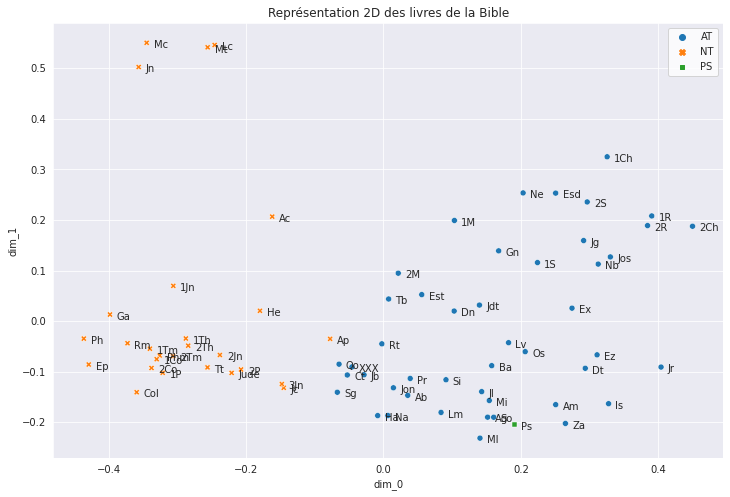

In [14]:
pca_mod = PCA(n_components=2)
X = pca_mod.fit_transform(vec_res)

df_livres_vectorized = pd.DataFrame({
    'testament' : df_livres['TESTAMENT'],
    'code_livre': df_livres['CODE_LIVRE'],
    'dim_0' : X[:,0],
    'dim_1' : X[:,1]})

plt.figure(figsize=(12,8))#, dpi=300)
sns.set_style("darkgrid")

g = sns.scatterplot(data=df_livres_vectorized, x='dim_0', y='dim_1', hue = 'testament', style="testament")
g.legend(facecolor = 'white')
g.set_title("Représentation 2D des livres de la Bible")

for i, txt in enumerate(df_livres_vectorized['code_livre']):
  g.annotate(s=txt, 
             xy=(df_livres_vectorized.loc[i, 'dim_0']+0.01, df_livres_vectorized.loc[i, 'dim_1']-0.01))

La visualisation graphique basée uniquement sur le contenu des texte est riche d'enseignements.
* La distinction Ancient Testament / Nouveau testament est très marquée.
* Au sein du groupe du Nouveau Testament, 2 groupes principaux
 * les 4 évangiles
 * Les lettres
* Le livre de l'Apocalypse est le livre du NT qui se rapproche le plus du groupe de l'AT.
* Les Actes des Apôtres, qui n'est ni un récit de la vie du Christ comme les Evangiles, ni un ensemble d'exhortations comme les Lettres, se retrouve isolé.


# Moteur de recommandation biblique

## Vectorisation par vecteurs Spacy

Nous avons vu plus haut qu'il est indispensable de transformer les textes en vecteurs numériques pour pouvoir les utiliser dans les algorithmes de traitement de données. Alors que nous avions utilisé la méthode Td-Idf, nous allons maintenant associer à chaque texte un vecteur calculé au préalable sur un [corpus](https://spacy.io/models/fr#fr_core_news_lg) d'articles de journaux.
Dans le model fr_core_news_lg proposé par la library spaCy, 500k vecteurs de dimension 300 sont mis à disposition, correspondant à 500k mots.

Chaque verset sera donc associé à un vecteur de dimension 300. Le vecteur d'un verset étant la moyenne des vecteurs des mots qui le composent.

Le principe du moteur de recommandation sera le suivant ↙
- Entrée d'un texte par l'utilisateur (quelques mots suffisent)
- Attribution d'un vecteur à ce texte
- Identification et présentation des versets les plus proches

Tout d'abord, une fonction permettant de trouver le vecteur spaCy d'un texte

In [15]:
import spacy
import fr_core_news_md

nlp = fr_core_news_md.load()

def return_sentence_vector(sentence):
  doc = nlp(sentence)
  return doc.vector

Le corpus biblique est enrichi des vecteurs pour chacun des versets (temps de calcul environ 5 minutes).

Le corpus enrichi est sauvegardé pour pouvoir être réutilisé.

In [16]:
# dure 4-5 minutes
vectors = data['TEXTE_CLEAN'].apply(return_sentence_vector)
df_vectors = pd.DataFrame(data = [vec for vec in vectors], columns = ['v'+str(i) for i in range(0, len(vectors[0]))])

df = pd.concat([data, df_vectors], axis=1)
df.to_parquet('/gdrive/MyDrive/Colab Notebooks/bible_aelf_vectors.parquet.gzip',compression='gzip')

## Moteur de recommandation



On commence par lire le fichier de données contenant les vecteurs

In [17]:
data = pd.read_parquet('/gdrive/MyDrive/Colab Notebooks/bible_aelf_vectors.parquet.gzip')

La fonction ci dessous prend en paramètre une chaine de caractères, la nettoie, lui associe un vecteur spaCy et retourne les versets les plus proches au sens de la distance cosine.

In [54]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import numpy as np

def propose_passage(txt, nb_proposions = 10, filter=None):

  better_phrase = clean_text(txt, remove_stop_words=True)
  vector = return_sentence_vector(better_phrase)
  
  if filter is not None:
    filtered_data = data.loc[data['TESTAMENT']==filter, :].reset_index()
    vector_subset = filtered_data.loc[:,filtered_data.columns.str.startswith('v')]
    distances = euclidean_distances(vector.reshape((1, -1)), vector_subset).reshape(-1)
    result = filtered_data.loc[np.argsort(distances, )[:nb_proposions], ['URL',  'VERSET','TEXTE']]
  else:
    vector_subset = data.loc[:, data.columns.str.startswith('v')]
    distances = euclidean_distances(vector.reshape((1, -1)), vector_subset).reshape(-1)
    result = data.loc[np.argsort(distances, )[:nb_proposions], ['URL',  'VERSET','TEXTE']]
  
  return result

Cette méthode permettant de rapprocher un texte quelconque d'un texte biblique peut avoir plusieus intérêts 
* retrouver un passage à partir d'une fraction de texte (un vieux souvenir de catéchisme par exemple ?😏)


In [55]:
propose_passage("que la lumière soit", nb_proposions=5)

,URL,VERSET,TEXTE
14397,https://www.aelf.org/bible/Gn/1,03,Dieu dit :\n« Que la lumière soit. »\nEt la lu...
19791,https://www.aelf.org/bible/Jn/1,08,"Cet homme n’était pas la Lumière,\nmais il éta..."
23304,https://www.aelf.org/bible/Lc/11,36,si ton corps tout entier est dans la lumière s...
30270,https://www.aelf.org/bible/Ps/35,10,En toi est la source de vie ; par ta lumière n...
23303,https://www.aelf.org/bible/Lc/11,35,Examine donc si la lumière qui est en toi n’es...


* proposer un passage de l'écriture pour accompagner une prière

In [56]:
propose_passage("je voudrais guérir de ma maladie", nb_proposions=5, filter='NT')

,URL,VERSET,TEXTE
3711,https://www.aelf.org/bible/Jn/5,06,"Jésus, le voyant couché là, et apprenant qu’il..."
4766,https://www.aelf.org/bible/Lc/7,21,"À cette heure-là, Jésus guérit beaucoup de gen..."
6468,https://www.aelf.org/bible/Mt/8,02,"Et voici qu’un lépreux s’approcha, se prostern..."
6539,https://www.aelf.org/bible/Mt/10,01,Alors Jésus appela ses douze disciples et leur...
4688,https://www.aelf.org/bible/Lc/5,31,Jésus leur répondit : « Ce ne sont pas les gen...


* trouver une référence biblique à une phrase connue

In [57]:
propose_passage("l'argent ne fait pas le bonheur", nb_proposions=5, filter = 'NT')

,URL,VERSET,TEXTE
1596,https://www.aelf.org/bible/Ac/8,20,"Pierre lui dit : « Périsse ton argent, et toi ..."
7181,https://www.aelf.org/bible/Mt/26,09,"On aurait pu, en effet, vendre ce parfum pour ..."
5181,https://www.aelf.org/bible/Lc/16,11,Si donc vous n’avez pas été dignes de confianc...
3412,https://www.aelf.org/bible/He/13,05,Que votre conduite ne soit pas inspirée par l’...
3461,https://www.aelf.org/bible/Jc/2,02,"Imaginons que, dans votre assemblée, arrivent ..."
